In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!nvidia-smi

Sat Aug 28 11:10:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning

     |████████████████████████████████| 2.6 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 50.8 MB/s 
     |████████████████████████████████| 3.3 MB 59.4 MB/s 
     |████████████████████████████████| 636 kB 59.3 MB/s 
     |████████████████████████████████| 918 kB 5.1 MB/s 
     |████████████████████████████████| 272 kB 63.8 MB/s 
     |████████████████████████████████| 118 kB 55.8 MB/s 
     |████████████████████████████████| 829 kB 56.5 MB/s 
     |████████████████████████████████| 1.3 MB 31.1 MB/s 
     |████████████████████████████████| 294 kB 61.5 MB/s 
     |████████████████████████████████| 142 kB 61.9 MB/s 


In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline  
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

from collections import Counter

Global seed set to 42


In [ ]:
# import dataset
train_df = pd.read_csv('drive/MyDrive/Biocreative/Biocreative/datasets/TRAIN.csv')
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head(), train_df.shape

(       pmid  ... Treatment
 0  33953243  ...         0
 1  33734063  ...         0
 2  32304745  ...         0
 3  34006330  ...         1
 4  32496253  ...         0
 
 [5 rows x 12 columns], (30738, 12))

In [ ]:
LABEL_COLUMNS = train_df.columns.tolist()[5:]

In [ ]:
print(LABEL_COLUMNS)

['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission', 'Treatment']


In [ ]:
# BERT_MODEL_NAME = 'dmis-lab/biobert-base-cased-v1.1'
# Ref : microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
# Ref 2.0 : lordtt13/COVID-SciBERT
BERT_MODEL_NAME = input("Enter Bert Model Name: ")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

Enter Bert Model Name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext


Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
train_df[LABEL_COLUMNS].sum().sort_values()

Epidemic Forecasting     1528
Case Report              2291
Transmission             3165
Mechanism                5414
Diagnosis                7456
Treatment               10091
Prevention              13998
dtype: int64

In [ ]:
MAX_TOKEN_COUNT = 512

### lstm embeddings

In [ ]:
titles = [title.lower() for title in train_df.title.to_list()]

In [ ]:
all_titles = ' '.join(titles)
# create a list of words
words = all_titles.split()

In [ ]:
#tokenization
import spacy

tok = spacy.load('en')
def tokenize (text):
  return [token.text for token in tok.tokenizer(text)]

In [ ]:
# Count all the words using Counter Method
counts = Counter(words)

total_words = len(words)
sorted_words = counts.most_common(total_words)

In [ ]:
print(counts)

Counter({'covid-19': 20235, ',': 6592, 'sars-cov-2': 5309, 'pandemic': 4869, 'coronavirus': 4269, 'patient': 3817, 'disease': 3658, 'infection': 2544, '2019': 2252, 'study': 2245, 'clinical': 2031, 'review': 2001, 'case': 1701, 'patients': 1635, 'care': 1563, 'transmission': 1365, 'treatment': 1281, 'severe': 1277, 'analysis': 1274, 'acute': 1234, 'health': 1213, 'management': 1208, 'respiratory': 1192, 'impact': 1176, 'novel': 1172, 'risk': 1149, 'outbreak': 1147, 'potential': 1052, 'china': 955, 'syndrome': 952, 'model': 859, 'systematic': 844, 'response': 830, 'pneumonia': 817, 'epidemic': 814, 'using': 781, 'hospital': 746, 'report': 732, 'among': 678, 'role': 673, 'experience': 661, 'mortality': 653, 'associated': 640, 'system': 639, 'early': 638, 'new': 629, 'virus': 622, 'cancer': 621, 'use': 608, '2': 607, '-': 606, 'therapy': 595, 'viral': 567, 'effect': 566, 'emergency': 564, 'control': 560, 'approach': 557, '2020': 552, 'practice': 547, 'surgery': 545, 'detection': 541, 'tim

In [ ]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 21110
num_words after: 9930


In [ ]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [ ]:
print(vocab2index)

{'': 0, 'UNK': 1, 'epidemiological': 2, 'characteristic': 3, 'effectiveness': 4, 'countermeasure': 5, 'contain': 6, 'coronavirus': 7, 'disease': 8, '2019': 9, 'ningbo': 10, 'city': 11, ',': 12, 'zhejiang': 13, 'province': 14, 'china': 15, 'transmission': 16, 'severe': 17, 'acute': 18, 'respiratory': 19, 'syndrome': 20, '2': 21, 'border': 22, 'quarantine': 23, 'air': 24, 'travel': 25, 'new': 26, 'zealand': 27, 'aotearoa': 28, 'risk': 29, 'factor': 30, 'severity': 31, 'mortality': 32, 'covid-19': 33, 'patient': 34, 'wuhan': 35, 'breaking': 36, 'global': 37, 'health': 38, 'crisis': 39, 'distribution': 40, 'growth': 41, 'rate': 42, 'outbreak': 43, 'tamil': 44, 'nadu': 45, 'regression': 46, 'approach': 47, 'corona': 48, 'virus': 49, 'paediatric': 50, 'inflammatory': 51, 'bowel': 52, 'diseases': 53, 'experience': 54, 'provisional': 55, 'guidance': 56, 'march': 57, '2020': 58, 'ibd': 59, 'porto': 60, 'group': 61, 'european': 62, 'society': 63, 'gastroenterology': 64, 'hepatology': 65, 'nutrit

In [ ]:
def encode_sentence(text, vocab2index, N=64):

  tokenized = tokenize(text)
  encoded = np.zeros(N, dtype=int)
  enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
  length = min(N, len(enc1))
  encoded[:length] = enc1[:length]
  return encoded, length

In [ ]:
train_df['title_int'] = train_df['title'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
train_df.head()

,pmid,title,abstract,keywords,label,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment,title_int
0,33953243,epidemiological characteristic effectiveness c...,novel coronavirus SARS-CoV-2 spread worldwide ...,NaN,Prevention;Transmission,0,0,0,0,1,1,0,"[[2, 3, 4, 5, 6, 7, 8, 9, 1, 1, 12, 1, 1, 12, ..."
1,33734063,Transmission Severe Acute Respiratory Syndrome...,strategy New Zealand Aotearoa eliminate corona...,NaN,Transmission,0,0,0,0,0,1,0,"[[1, 1, 1, 1, 1, 1, 21, 1, 1, 1, 1, 12, 1, 1, ..."
2,32304745,"Risk factor disease severity , unimprovement ,...","OBJECTIVE December 2019 , coronavirus disease ...",covid-19;disease severity;mortality;patients;u...,Diagnosis,0,1,0,0,0,0,0,"[[1, 30, 8, 31, 12, 1, 12, 32, 1, 34, 1, 12, 1..."
3,34006330,COVID-19 breaking global health crisis,Coronavirus disease 2019 COVID-19 second pande...,NaN,Prevention;Transmission;Treatment,0,0,0,0,1,1,1,"[[1, 36, 37, 38, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,32496253,Distribution growth rate COVID-19 outbreak Tam...,Background country affected pandemic outbreak ...,covid-19 outbreak;tamil nadu;decay rate;growth...,Epidemic Forecasting;Prevention,0,0,1,0,1,0,0,"[[1, 41, 42, 1, 43, 1, 1, 1, 431, 2462, 46, 47..."


In [ ]:
class TopicAnnotationDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: AutoTokenizer,
    max_token_len: int = 512,
    title_max_token_len: int = 48
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    self.title_max_token_len = title_max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index=int):
    
    data_row = self.data.iloc[index]

    abstract_text = data_row.abstract
    labels = data_row[LABEL_COLUMNS]

    title_text = data_row.title
    title_ints = data_row.title_int

    encoding = self.tokenizer.encode_plus(
        abstract_text,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    return dict(
        abstract_text=abstract_text,
        title_text=title_text,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        title_ints=torch.from_numpy(title_ints[0].astype(np.int32)),
        labels=torch.FloatTensor(labels) 
    )  

In [ ]:
train_dataset = TopicAnnotationDataset(
    train_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
class TopicAnnotationDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    
    self.train_dataset =  TopicAnnotationDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )

    self.test_dataset = TopicAnnotationDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):

    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):

    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
%pwd

'/content'

In [ ]:
val_df = pd.read_csv("/content/drive/MyDrive/Biocreative/Biocreative/datasets/VAL.csv")
val_df = val_df.sample(frac=1).reset_index(drop=True)
val_df.shape

(3423, 12)

In [ ]:
val_df['title_int'] = val_df['title'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
val_df.head()

,pmid,title,abstract,keywords,label,Case Report,Diagnosis,Epidemic Forecasting,Mechanism,Prevention,Transmission,Treatment,title_int
0,33073359,Divergent SARS-CoV-2-specific T- B-cell respon...,Severe acute respiratory syndrome coronavirus ...,cd4+ t cells;covid-19;igg;sars-cov-2;antibody ...,Treatment;Diagnosis;Mechanism,0,1,0,1,0,0,1,"[[1, 1, 431, 1, 1, 1, 431, 1305, 148, 17, 229,..."
1,32939620,use imaging COVID-19-results global survey Int...,OBJECTIVES survey conducted International Soci...,covid-19 pandemic;radiology department;survey,Diagnosis,0,1,0,0,0,0,0,"[[195, 187, 1, 37, 503, 1, 1, 1, 0, 0, 0, 0, 0..."
2,32597503,Melatonin restores neutrophil function prevent...,"Melatonin chronobiotic hormone , regulate huma...",2-aapa;bso;netosis;glutathione;glutathione red...,Treatment;Prevention;Mechanism,0,0,0,1,1,0,1,"[[1, 1, 2188, 121, 5417, 8655, 1957, 9746, 437..."
3,32953842,Gender medicine Lessons COVID-19 medical condi...,"Gender-specific difference prevalence , incide...",adolescent health;asthma;covid-19;chronic kidn...,Prevention,0,0,0,0,1,0,0,"[[1, 225, 1, 1, 682, 2346, 1065, 38, 1019, 0, ..."
4,32087623,Comparison clinical characteristic RNA positiv...,Objective raise awareness 2019 novel coronavir...,2019 novel coronavirus;clinical characteristic...,Mechanism;Diagnosis,0,1,0,1,0,0,0,"[[1, 169, 3, 1, 1478, 112, 34, 6416, 2890, 7, ..."


In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 8

data_module = TopicAnnotationDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
Label_count = train_df[LABEL_COLUMNS].sum().to_dict()
count = list(Label_count.values())
max_val = max(count)
class_weight = [max_val/val for val in count]
print(class_weight)

[6.109995635093846, 1.8774141630901287, 9.160994764397905, 2.5855190247506465, 1.0, 4.4227488151658765, 1.3871766921018729]


In [ ]:
# print label and corresponding weights
dict(zip(LABEL_COLUMNS, class_weight))

{'Case Report': 6.109995635093846,
 'Diagnosis': 1.8774141630901287,
 'Epidemic Forecasting': 9.160994764397905,
 'Mechanism': 2.5855190247506465,
 'Prevention': 1.0,
 'Transmission': 4.4227488151658765,
 'Treatment': 1.3871766921018729}

In [ ]:
class_weight = torch.tensor(class_weight, device="cuda")

In [ ]:
# download glove word embedding
# !wget --header="Host: nlp.stanford.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.456156586.1539718115; _gid=GA1.2.491677602.1539718115; _gat=1" --header="Connection: keep-alive" "https://nlp.stanford.edu/data/glove.6B.zip" -O "glove.6B.zip" -c

In [ ]:
# !unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
%cd drive/MyDrive/Biocreative/Biocreative/

/content/drive/MyDrive/Biocreative/Biocreative


In [ ]:
%ls

'Analyze Datasets'/       Label_embed.pt
 Angry_bert/             'Label specific attention (LSAN)'/
 checkpoints_and_logs/   'Label wise attention (LWAN)'/
 cord19-checkpoints/      Models/
 cord19-lightning_logs/  'Multi label classifiers'/
 datasets/               'plots and results'/
 glove.6B.100d.txt       'PyCaret '/
 glove.6B.200d.txt        results.xlsx
 glove.6B.300d.txt        Selinium_Scrapper.ipynb
 glove.6B.50d.txt         T5_Model.ipynb
 glove.6B.zip


In [ ]:
def load_glove_vectors(glove_file="glove.6B.300d.txt"):
  """Load the glove word vectors"""
  word_vectors = {}
  with open(glove_file) as f:
      for line in f:
          split = line.split()
          word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
  return word_vectors

In [ ]:
def get_emb_matrix(pretrained, word_counts, emb_size = 300):
  """ Creates embedding matrix from word vectors"""
  vocab_size = len(word_counts) + 2
  vocab_to_idx = {}
  vocab = ["", "UNK"]
  W = np.zeros((vocab_size, emb_size), dtype="float32")
  W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
  W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
  vocab_to_idx["UNK"] = 1
  i = 2
  for word in word_counts:
      if word in word_vecs:
          W[i] = word_vecs[word]
      else:
          W[i] = np.random.uniform(-0.25,0.25, emb_size)
      vocab_to_idx[word] = i
      vocab.append(word)
      i += 1   
  return W, np.array(vocab), vocab_to_idx

In [ ]:
word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts)

In [ ]:
class FFN(nn.Module):
  def __init__(self, in_feat, out_feat, dropout):
      super(FFN, self).__init__()
      self.in2hid = nn.Linear(in_feat, in_feat)
      self.hid2out = nn.Linear(in_feat, out_feat)

      self.activation = nn.ReLU()
      self.dropout = nn.Dropout(dropout)

  def forward(self, input):
      hid = self.activation(self.dropout(self.in2hid(input)))
      return self.hid2out(hid)

In [ ]:
# columns list
print(list(train_df.columns))

['pmid', 'title', 'abstract', 'keywords', 'label', 'Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission', 'Treatment', 'title_int']


In [ ]:
class TopicAnnotationTagger(pl.LightningModule):

  def __init__(
      self, 
      n_classes: int, 
      vocab_size,
      embedding_dim,
      bilstm_hidden_dim,
      glove_weights,
      n_training_steps=None, 
      n_warmup_steps=None,
      ffn_dim: int = 512,
      out_feat: int = 768, 
      dropout=0.2,
  ):
    
    super().__init__()
    self.bert = AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss(weight=class_weight)
    self.sigmoid = nn.Sigmoid()

    # angry-bert layers
    self.ffn_dim = ffn_dim
    self.out_feat = out_feat
    self.dropout = nn.Dropout(p=dropout)
    self.activation = nn.ReLU()
    
    self.gate = nn.Linear(
        (self.bert.config.hidden_size + bilstm_hidden_dim * 2), 
        self.ffn_dim
    )

    self.ffn = FFN(self.ffn_dim, out_feat, dropout=0.2)
    self.classifier = nn.Linear(self.out_feat, n_classes)

    # lstm layers
    self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
    self.embeddings.weight.requires_grad = False ## freeze embeddings
    self.lstm = nn.LSTM(embedding_dim, bilstm_hidden_dim, batch_first=True, bidirectional=True)
    # self.linear = nn.Linear(hidden_dim, 5)
    self.lstm_dropout = nn.Dropout(0.2) 

  def forward(self, input_ids, attention_mask, title_ints, labels=None):

    bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
    # pooler_output (batch_size x hidden_size)
    encoded_output_bert = bert_outputs.pooler_output

    # bilstm layer
    self.lstm.flatten_parameters()

    embeddings = self.lstm_dropout(self.embeddings(title_ints))
    
    # bilstm_output (batch_size, bilst_hidden_dim)
    bilstm_out, (ht, ct) = self.lstm(embeddings)
    
    # gate-fusion
    gatein = torch.cat((encoded_output_bert, bilstm_out[:, -1, :]), dim=-1)
    chosen = self.activation(self.dropout(self.gate(gatein)))

    res = self.ffn(chosen)

    # classification
    output = self.classifier(res)
    output = torch.sigmoid(output)

    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    title_ints = batch["title_ints"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, title_ints, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    title_ints = batch["title_ints"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, title_ints, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    title_ints = batch["title_ints"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, title_ints, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):

    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
            )
        )

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(7684, 38420)

In [ ]:
model = TopicAnnotationTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps,
    vocab_size=len(counts)+2,
    embedding_dim=300,
    bilstm_hidden_dim=384,
    glove_weights=pretrained_weights
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
%pwd

'/content/drive/My Drive/Biocreative/Biocreative'

In [ ]:
cd '/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/'

/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs


In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="ANGRYBERT-lstm-checkpoints",
    filename="ANGRYBERT-lstm-best-checkpoint",
    save_top_k=3,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [ ]:
logger = TensorBoardLogger("ANGRYBERT-lstm-lightning_logs", name="topic-annotations")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=True,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name         | Type      | Params
--------------------------------------------
0  | bert         | BertModel | 109 M 
1  | criterion    | BCELoss   | 0     
2  | sigmoid      | Sigmoid   | 0     
3  | dropout      | Dropout   | 0     
4  | activation   | ReLU      | 0     
5  | gate         | Linear    | 786 K 
6  | ffn          | FFN       | 656 K 
7  | classifier   | Linear    | 5.4 K 
8  | embeddings   | Embedding | 3.0 M 
9  | lstm         | LSTM      | 2.1 M 
10 | lstm_dropout | Dropout   | 0     
--------------------------------------------
113 M     Trainable params
3.0 M     Non-trainable params
116 M     Total params
464.073   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:398: LightningDeprecationWarning: One of the returned values {'predictions', 'labels'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
Epoch 0, global step 3842: val_loss reached 0.46164 (best 0.46164), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/ANGRYBERT-lstm-checkpoints/ANGRYBERT-lstm-best-checkpoint.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 7685: val_loss reached 0.35932 (best 0.35932), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/ANGRYBERT-lstm-checkpoints/ANGRYBERT-lstm-best-checkpoint-v1.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 11528: val_loss reached 0.32468 (best 0.32468), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/ANGRYBERT-lstm-checkpoints/ANGRYBERT-lstm-best-checkpoint-v2.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 15371: val_loss reached 0.38445 (best 0.32468), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/ANGRYBERT-lstm-checkpoints/ANGRYBERT-lstm-best-checkpoint.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 19214: val_loss reached 0.34190 (best 0.32468), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/ANGRYBERT-lstm-checkpoints/ANGRYBERT-lstm-best-checkpoint.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 23057: val_loss was not in top 3


### Test

In [ ]:
trained_model = TopicAnnotationTagger.load_from_checkpoint('/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/ANGRYBERT-lwan-checkpoints-upd1/ANGRYBERT-lwan-best-checkpoint-upd1-v2.ckpt', n_classes=7)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-unc

In [ ]:
trained_model.freeze()

### Evaluation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = TopicAnnotationDataset(
    val_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
predictions = []
labels = []

for item in tqdm(val_dataset):

  _, prediction = trained_model(
      item["input_ids"].unsqueeze(dim=0).to(device),
      item["attention_mask"].unsqueeze(dim=0).to(device),    
      item["title_input_ids"].unsqueeze(dim=0).to(device),
      item["title_attention_mask"].unsqueeze(dim=0).to(device)
  )
  
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/3423 [00:00<?, ?it/s]

#### data analysis

In [ ]:
# convert prediction in boolean labels
y_pred = (predictions > 0.65).type(torch.uint8)
y_true = labels  

In [ ]:
# count non-zero values
true_counts = y_true.count_nonzero(dim=1)
pred_counts = y_pred.count_nonzero(dim=1)

In [ ]:
# dict mapping for count -> key 
unique, counts = true_counts.unique(return_counts=True)
true_count_dict = dict(zip(unique.tolist(), counts.tolist()))
print(true_count_dict)

{1: 18927, 2: 8069, 3: 930, 4: 130, 5: 19}


In [ ]:
X = [1, 2, 3, 4, 5]
for label in X:
  try:
    val = true_count_dict[label]
  except Exception as e:
    true_count_dict[label] = 0

true_count_dict

{1: 18927, 2: 8069, 3: 930, 4: 130, 5: 19}

In [ ]:
# dict mapping for count -> key
pred_count_dict = {
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0
}

for idx, value in enumerate(true_counts):
  if value == pred_counts[idx]: 
    pred_count_dict[value.tolist()] += 1
  else:
    pass

pred_count_dict

{1: 17165, 2: 5652, 3: 380, 4: 25, 5: 2}

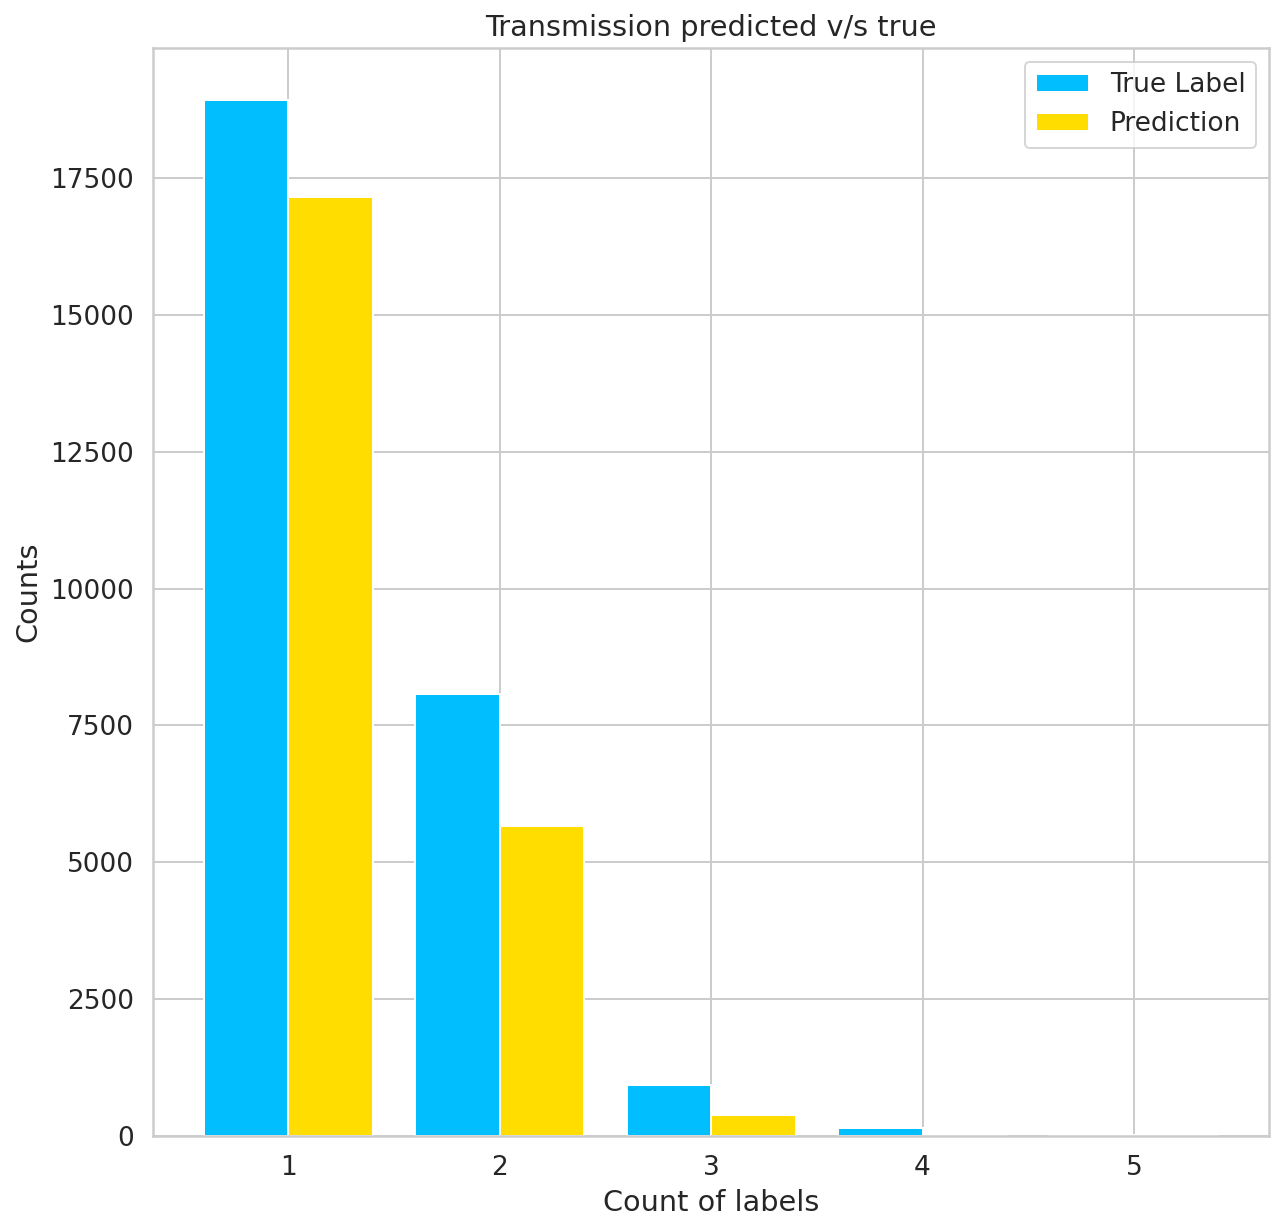

In [ ]:
X = ["1", "2", "3", "4", "5"]

# creating the dataset 
keys = list(pred_count_dict.keys()) 
pred_values = list(pred_count_dict.values()) 
true_values = list(true_count_dict.values())

keys = np.array(keys)

fig = plt.figure(figsize = (10, 10)) 
  
# creating the bar plot 
plt.bar(keys - 0.2, true_values, 0.4, label = 'True Label')
plt.bar(keys + 0.2, pred_values, 0.4, label = 'Prediction')

plt.xticks(keys, X)
plt.xlabel("Count of labels")
plt.ylabel("Counts")
plt.title("Transmission predicted v/s true")
plt.legend()
plt.show() 

In [ ]:
class_dict_pred = dict(zip(LABEL_COLUMNS, [0]*7))
class_dict_true = dict(zip(LABEL_COLUMNS, [0]*7))
class_dict_pred, class_dict_true

({'Case Report': 0,
  'Diagnosis': 0,
  'Epidemic Forecasting': 0,
  'Mechanism': 0,
  'Prevention': 0,
  'Transmission': 0,
  'Treatment': 0},
 {'Case Report': 0,
  'Diagnosis': 0,
  'Epidemic Forecasting': 0,
  'Mechanism': 0,
  'Prevention': 0,
  'Transmission': 0,
  'Treatment': 0})

In [ ]:
THRESHOLD = 0.5
print(LABEL_COLUMNS)

for item in val_dataset:

  labels = item["labels"].numpy()
  count = np.count_nonzero(labels)

  if count == 2:
    
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )

    # print((prediction > THRESHOLD).type(torch.uint8))

    prediction = prediction.cpu()

    for idx, key in enumerate(class_dict_pred.keys()):

      class_dict_pred[key] += (prediction[0, idx] > THRESHOLD).type(torch.uint8)

    for idx, key in enumerate(class_dict_true.keys()):
      class_dict_true[key] += labels[idx]

['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission', 'Treatment']


In [ ]:
for key, value in class_dict_pred.items():

  class_dict_pred[key] = value.numpy().item()

print(class_dict_pred)
print(class_dict_true)

{'Case Report': 2, 'Diagnosis': 112, 'Epidemic Forecasting': 52, 'Mechanism': 45, 'Prevention': 18, 'Transmission': 3, 'Treatment': 21}
{'Case Report': 0.0, 'Diagnosis': 119.0, 'Epidemic Forecasting': 19.0, 'Mechanism': 129.0, 'Prevention': 482.0, 'Transmission': 755.0, 'Treatment': 6.0}


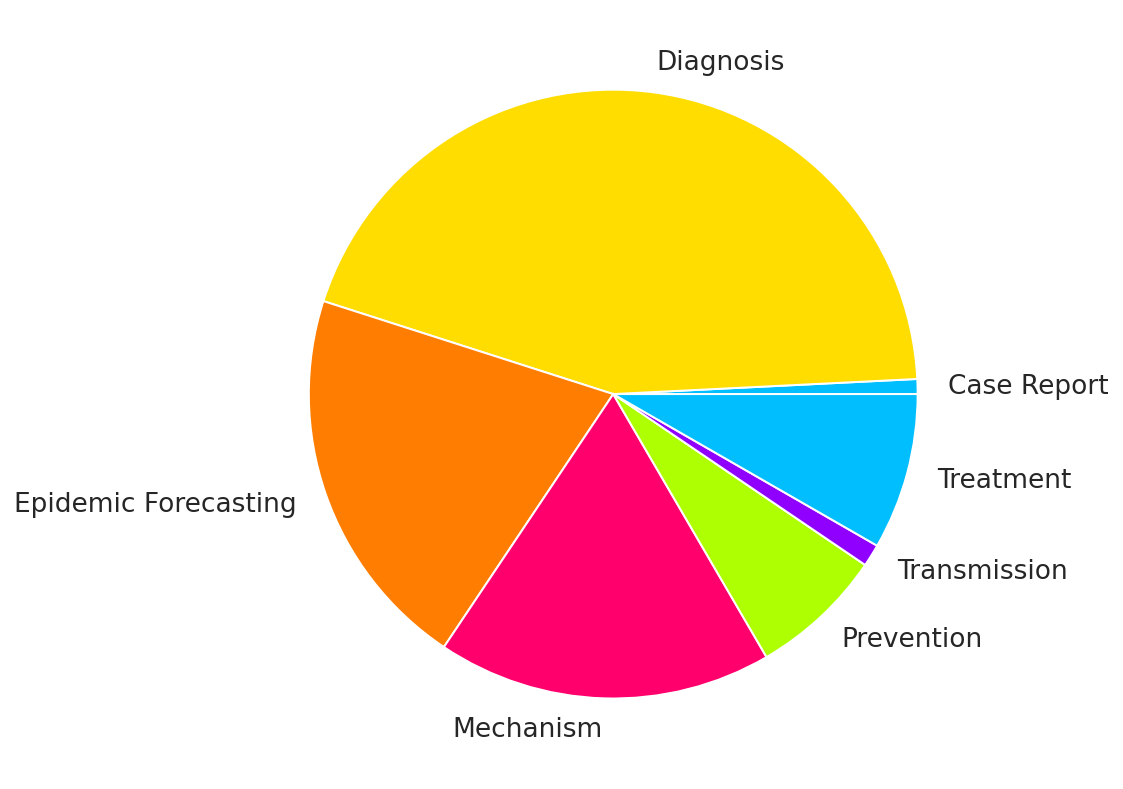

In [ ]:
keys = class_dict_pred.keys()
values = class_dict_pred.values()

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(values, labels = keys)
  
# show plot
plt.show()

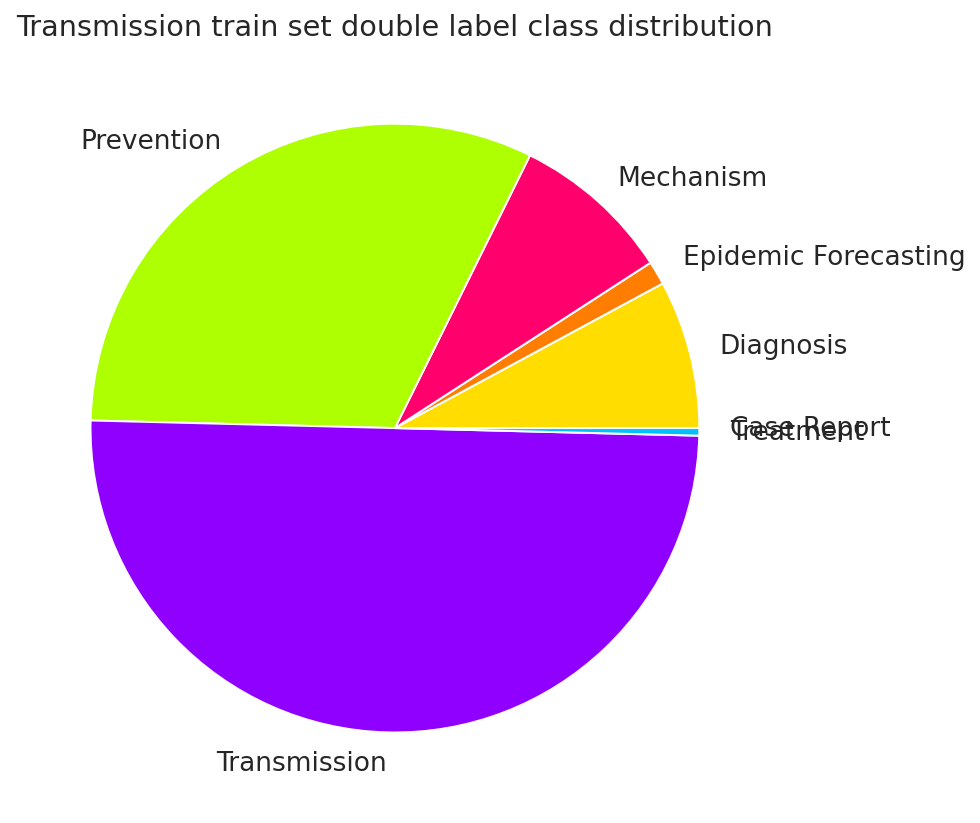

In [ ]:
keys = class_dict_true.keys()
values = class_dict_true.values()

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(values, labels = keys)
plt.title("Transmission train set double label class distribution")
# show plot
plt.show()

#### Accuracy

In [ ]:
THRESHOLD = 0.5

In [ ]:
# calculating the accuracy of the model
accuracy(predictions, labels, threshold=THRESHOLD)

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.accuracy.accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


tensor(0.9518)

#### ROC for each tag

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Case Report: 0.9909360408782959
Diagnosis: 0.9755405187606812
Epidemic Forecasting: 0.9932175874710083
Mechanism: 0.98218834400177
Prevention: 0.975793719291687
Transmission: 0.9831932187080383
Treatment: 0.9715996980667114


/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


#### classification report for each class

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

                      precision    recall  f1-score   support

         Case Report     0.8924    0.9032    0.8978       248
           Diagnosis     0.8733    0.8540    0.8635       815
Epidemic Forecasting     0.8176    0.8373    0.8274       166
           Mechanism     0.8827    0.8609    0.8717       568
          Prevention     0.9129    0.9231    0.9180      1613
        Transmission     0.7740    0.8466    0.8087       352
           Treatment     0.8578    0.8921    0.8746      1075

           micro avg     0.8753    0.8877    0.8815      4837
           macro avg     0.8587    0.8739    0.8659      4837
        weighted avg     0.8760    0.8877    0.8816      4837
         samples avg     0.8983    0.9145    0.8909      4837



In [ ]:
THRESHOLD = [0.5, 0.55, 0.6, 0.65, 0.67, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in THRESHOLD:
  y_pred = predictions.numpy()
  y_true = labels.numpy()

  upper, lower = 1, 0

  y_pred = np.where(y_pred > threshold, upper, lower)

  print(f"Threshold: {threshold}")

  print(
      classification_report(
          y_true,
          y_pred,
          digits=4,
          target_names=LABEL_COLUMNS,
          zero_division=0
          )
      )

Threshold: 0.5
                      precision    recall  f1-score   support

         Case Report     0.8924    0.9032    0.8978       248
           Diagnosis     0.8733    0.8540    0.8635       815
Epidemic Forecasting     0.8176    0.8373    0.8274       166
           Mechanism     0.8827    0.8609    0.8717       568
          Prevention     0.9129    0.9231    0.9180      1613
        Transmission     0.7740    0.8466    0.8087       352
           Treatment     0.8578    0.8921    0.8746      1075

           micro avg     0.8753    0.8877    0.8815      4837
           macro avg     0.8587    0.8739    0.8659      4837
        weighted avg     0.8760    0.8877    0.8816      4837
         samples avg     0.8983    0.9145    0.8909      4837

Threshold: 0.55
                      precision    recall  f1-score   support

         Case Report     0.8960    0.9032    0.8996       248
           Diagnosis     0.8844    0.8356    0.8593       815
Epidemic Forecasting     0.8303    

In [ ]:
THRESHOLD = [threshold/100 for threshold in range(10, 100, 1)]
print(THRESHOLD)

[0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


In [ ]:
Class_report = dict()

for threshold in THRESHOLD:
  y_pred = predictions.numpy()
  y_true = labels.numpy()

  upper, lower = 1, 0

  y_pred = np.where(y_pred > threshold, upper, lower)

  Class_report[f"THRESHOLD:{threshold}"] = classification_report(
      y_true,
      y_pred,
      target_names=LABEL_COLUMNS,
      zero_division=0,
      output_dict=True
  )

In [ ]:
micro_F1_Scores = [Class_report[key]["micro avg"]["f1-score"] for key in Class_report.keys()]
macro_F1_Scores = [Class_report[key]["macro avg"]["f1-score"] for key in Class_report.keys()]

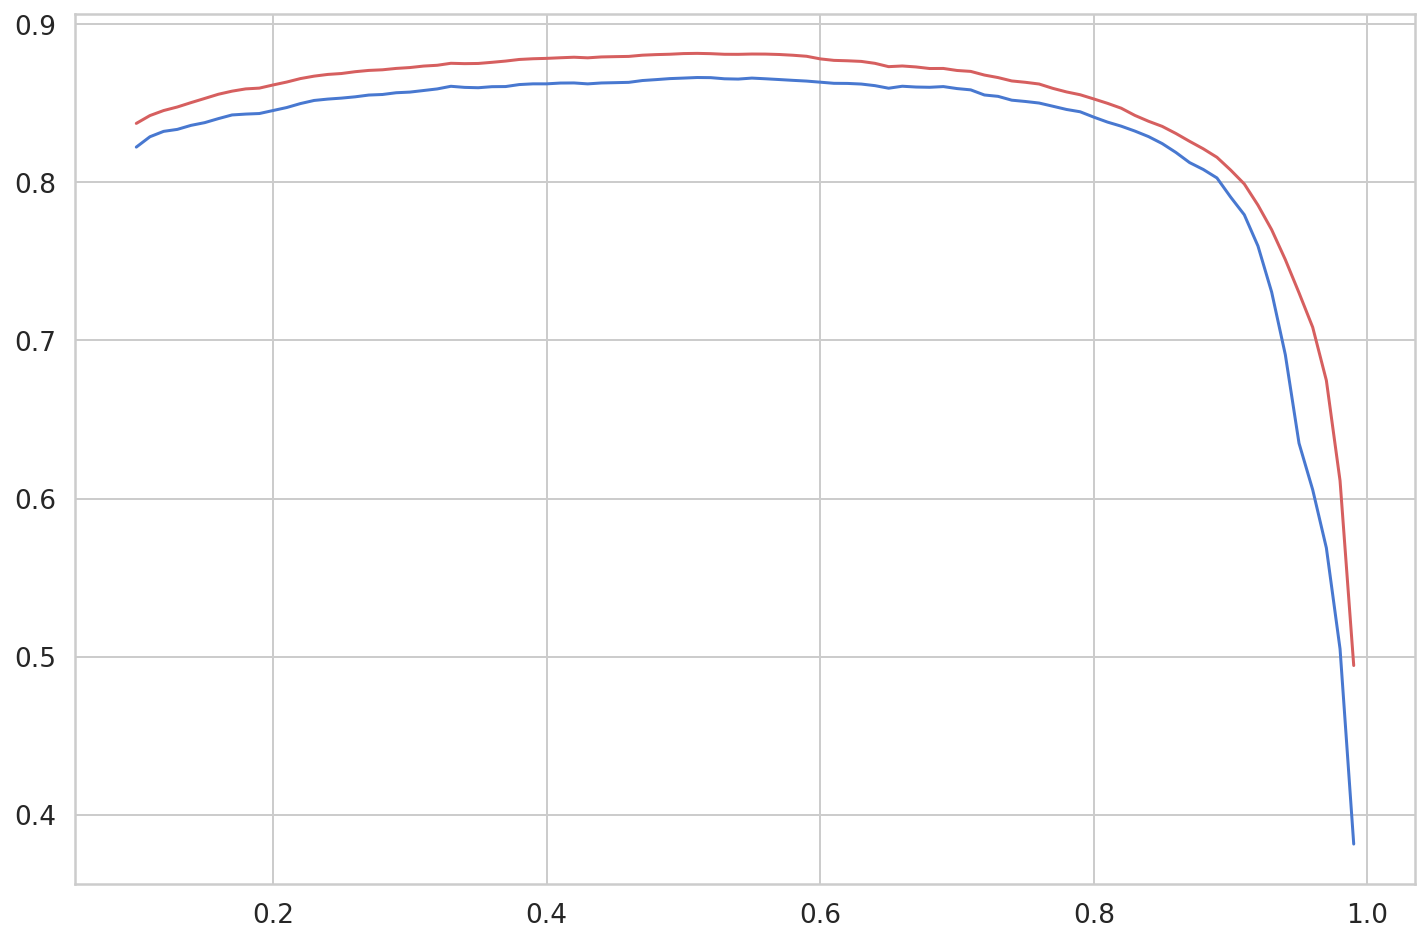

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

x = np.arange(10, 100, 1)/100
y1 = np.array(micro_F1_Scores)
y2 = np.array(macro_F1_Scores)

plt.plot(x, y1, 'r')  
plt.plot(x, y2, 'b') 
plt.show()

In [ ]:
max(micro_F1_Scores), np.argmax(micro_F1_Scores), x[41]

(0.8815789473684209, 41, 0.51)